## Analyze whether early or late snow changes more year to year or place to place.

In [3]:
import pandas as pd
import numpy as np
import urllib
import math

In [2]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
import numpy as np
from lib.numpy_pack import packArray,unpackArray
from lib.spark_PCA import computeCov
from lib.computeStatistics import *

In [5]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
state='NY'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%state
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

keys from STAT= dict_keys(['TMAX', 'SNOW', 'SNWD', 'TMIN', 'PRCP', 'TOBS'])


In [6]:
#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(state,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

8026
+-----------+-----------+--------------------+----+-----------------+------------------+-------------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+------------------+-----------+----------+--------+---------+---------+-----+-----------------+
|    Station|Measurement|              Values|Year|          coeff_1|           coeff_2|            coeff_3|           coeff_4|           coeff_5|             res_1|               res_2|               res_3|               res_4|               res_5|          res_mean|  total_var|Dist_coast|Latitude|Longitude|Elevation|State|             Name|
+-----------+-----------+--------------------+----+-----------------+------------------+-------------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+------------------+-----------+----------+--------+-----

In [7]:
print(df.columns)

['Station', 'Measurement', 'Values', 'Year', 'coeff_1', 'coeff_2', 'coeff_3', 'coeff_4', 'coeff_5', 'res_1', 'res_2', 'res_3', 'res_4', 'res_5', 'res_mean', 'total_var', 'Dist_coast', 'Latitude', 'Longitude', 'Elevation', 'State', 'Name']


In [8]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
#Features=', '.join(['coeff_1', 'coeff_2', 'coeff_3', 'elevation', 'latitude', 'longitude',\
#          'res_1', 'res_2', 'res_3', 'res_mean', 'year'])
Features='station, year, coeff_2'
Query="SELECT %s FROM weather"%Features
print(Query)
pdf = sqlContext.sql(Query).toPandas()
pdf.head()

SELECT station, year, coeff_2 FROM weather


,station,year,coeff_2
0,USC00306411,1945,4339.126274
1,USC00303102,1945,2949.545597
2,USC00305711,1959,-1751.907933
3,USC00308080,1952,-2533.000946
4,USC00300785,1963,-1508.071719


In [9]:
year_station_table=pdf.pivot(index='year', columns='station', values='coeff_2')
year_station_table.head(10)

station,USC00300015,USC00300023,USC00300047,USC00300055,USC00300063,USC00300077,USC00300085,USC00300090,USC00300093,USC00300159,...,USW00014786,USW00014797,USW00014798,USW00094704,USW00094725,USW00094728,USW00094745,USW00094789,USW00094790,USW00094794
year,,,,,,,,,,,,,,,,,,,,,
1892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1899,NaN,-94.738399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900,-259.601609,-295.514670,NaN,NaN,NaN,NaN,-828.739172,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1901,-1348.405811,97.415029,NaN,NaN,NaN,NaN,121.763990,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Estimating the effect of the year vs the effect of the station

To estimate the effect of time vs. location on the second eigenvector coefficient we
compute:

* The average row: `mean-by-station`
* The average column: `mean-by-year`

We then compute the RMS before and after subtracting either  the row or the column vector.

In [11]:
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

mean_by_year=np.nanmean(year_station_table,axis=1)
mean_by_station=np.nanmean(year_station_table,axis=0)
tbl_minus_year = (year_station_table.transpose()-mean_by_year).transpose()
tbl_minus_station = year_station_table-mean_by_station

print('total RMS                   = ',RMS(year_station_table))
print('RMS removing mean-by-station= ',RMS(tbl_minus_station))
print('RMS removing mean-by-year   = ',RMS(tbl_minus_year))

total RMS                   =  746.4242498619901
RMS removing mean-by-station=  713.9992355494542
RMS removing mean-by-year   =  543.967840314118


In [13]:
T=year_station_table
print('initial RMS=',RMS(T))
for i in range(5):
    mean_by_year=np.nanmean(T,axis=1)
    T=(T.transpose()-mean_by_year).transpose()
    print(i,'after removing mean by year    =',RMS(T))
    mean_by_station=np.nanmean(T,axis=0)
    T=T-mean_by_station
    print(i,'after removing mean by stations=',RMS(T))

initial RMS= 746.4242498619901
0 after removing mean by year    = 543.967840314118
0 after removing mean by stations= 509.7023889469642
1 after removing mean by year    = 509.08428782018143
1 after removing mean by stations= 509.03315203806187
2 after removing mean by year    = 509.0271904497572
2 after removing mean by stations= 509.02636345222885
3 after removing mean by year    = 509.0262286601185
3 after removing mean by stations= 509.0262018326333
4 after removing mean by year    = 509.0261951819865
4 after removing mean by stations= 509.02619319041


In [21]:
T['mean_by_year']=mean_by_year
T['mean_by_year'].head()

year
1892   -0.333379
1893   -0.429132
1895   -0.524884
1896   -0.778554
1897   -0.129935
Name: mean_by_year, dtype: float64

Populating the interactive namespace from numpy and matplotlib


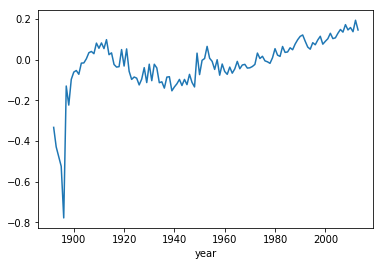

In [23]:
%pylab inline
T['mean_by_year'].plot();